<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 1.15.0


AttributeError: module 'tensorflow._api.v1.config' has no attribute 'list_physical_devices'

### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")#used in order to fill the missing values
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [7]:
#we have to add a padding token to the unique words
words = list(set(data["Word"].values))
words.append("ENDPAD")# to this word list, append a token corresponding to the padding
num_words = len(words)

In [9]:
#we have to add a padding token to the unique tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)# to this tag list, append a token corresponding to the padding

### Task 3: Retrieve Sentences and Corresponsing Tags

In [10]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1 #create a counter to track the no of senteces
        self.data = data # we are going to pass the entire data
        self.empty = False
        #group sentences into tuples containing 3 values:word,pos,Tag by getting their values and converting into a list
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        #now apply the agg_fun to the sentences, this is done by grouping sentences into data and splitting entire list into sub-list
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [12]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [14]:
#build 2 dictionaries, 1 to represent words as numerical values/unique indices,2nd representing tagstarget variable and assigning them unique indices
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

#below ouptut will show each token having a unique index

In [15]:
word2idx

{'300-km': 1,
 'Camel': 2,
 'simultaneously': 3,
 'celebrations': 4,
 'artillery': 5,
 'graveyard': 6,
 'Cong.': 7,
 'Yong-nam': 8,
 'Yoshimasa': 9,
 'disgusting': 10,
 'Unmasking': 11,
 'fails': 12,
 'catastrophic': 13,
 'Devices': 14,
 'Clemens': 15,
 'watching': 16,
 'Mezerhane': 17,
 'coupled': 18,
 'Endeavouris': 19,
 'girlfriend': 20,
 'failure': 21,
 'accounting': 22,
 'Saboor': 23,
 '180': 24,
 'deliberate': 25,
 'Balakot': 26,
 'Gem': 27,
 'Aleman': 28,
 'Ghormley': 29,
 'ploy': 30,
 'sacks': 31,
 'hundreds': 32,
 '2030': 33,
 'soft': 34,
 'tetrahydrogestrinone': 35,
 'alleys': 36,
 'resembled': 37,
 'Novaya': 38,
 'Compact': 39,
 'modernize': 40,
 'Chiapas': 41,
 'extinguished': 42,
 'candlelit': 43,
 'Zinedine': 44,
 '2,17,000': 45,
 'town': 46,
 'enough': 47,
 'Elevators': 48,
 'Teikoku': 49,
 'Hemisphere': 50,
 'largest': 51,
 'checkpoint': 52,
 'Squibb': 53,
 'budgeted': 54,
 'Pensacola': 55,
 'births': 56,
 'Fifty-four': 57,
 'Chambliss': 58,
 'Such': 59,
 'largely': 60,

### Task 5: Padding Input Sentences and Creating Train/Test Splits

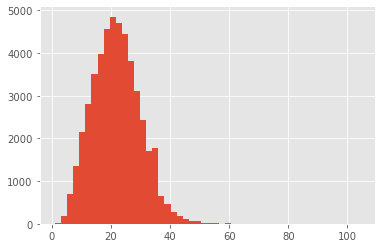

In [16]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Task 7: Train the Model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

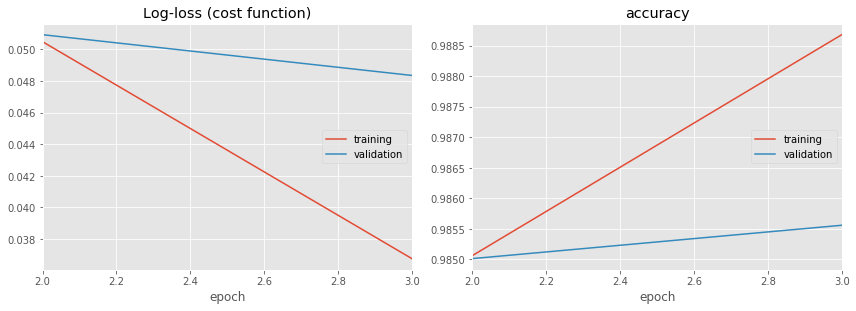

Log-loss (cost function):
training   (min:    0.037, max:    0.181, cur:    0.037)
validation (min:    0.048, max:    0.066, cur:    0.048)

accuracy:
training   (min:    0.958, max:    0.989, cur:    0.989)
validation (min:    0.981, max:    0.986, cur:    0.986)

Epoch 00003: val_loss improved from 0.05093 to 0.04835, saving model to model_weights.h5
38367/38367 [==============================] - 228s 6ms/sample - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.0484 - val_accuracy: 0.9856
CPU times: user 15min 48s, sys: 27.2 s, total: 16min 15s
Wall time: 11min 41s


In [18]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

### Task 8: Evaluate Named Entity Recognition Model

In [19]:
model.evaluate(x_test, y_test)

9592/9592 [==============================] - 12s 1ms/sample - loss: 0.0484 - accuracy: 0.9856


[0.04835232572507321, 0.9855588]

In [29]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
United         B-org	B-org
Nations        I-org	I-org
has            O	O
been           O	O
under          O	O
fire           O	O
for            O	O
failing        O	O
to             O	O
stop           O	O
ongoing        O	O
ethnic         O	O
violence       O	O
in             O	O
Ituri          B-geo	B-geo
.              O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surre